In [1]:
import sys
import pprint
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Change to the correct path
sys.path.append('aRMSD/armsd/')
sys.path.append('../../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

import torch

In [2]:
from ase.io import read
from ase.neb import NEB, SingleCalculatorNEB, NEBTools
from ase.optimize import MDMin, BFGS, QuasiNewton, FIRE
from ase.md.langevin import *
from ase.md.verlet import *
from ase import Atoms
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal,second
from ase.vibrations import Vibrations

from nff.io.ase import NeuralFF, AtomsBatch
from nff.data import Dataset
from nff.train import load_model, evaluate
from nff.md.utils import *
import nff.utils.constants as const
from nff.nn.tensorgrad import *

from nff.reactive_tools import *

In [3]:
from rdkit import RDLogger
import logging
import re
from rdkit.Chem import AllChem as Chem
PERIODICTABLE = Chem.GetPeriodicTable()

## Specify the reactive GCNN FF

In [4]:
nff_dir = 'reactive_models/diels_alder/'
nff = NeuralFF.from_file(nff_dir, device='cuda:0')

## Neural NEB

In [5]:
import nglview

view_rxt = nglview.show_ase(xyz_to_ase_atoms("reactive_xyzs/da_r_m062x_def2svp.xyz"))
view_pdt = nglview.show_ase(xyz_to_ase_atoms("reactive_xyzs/da_p_m062x_def2svp.xyz"))

In [7]:
view_rxt

NGLWidget(n_components=1)

In [8]:
view_pdt

NGLWidget()

In [9]:
rxn_name = 'diels-alder'

images = neural_neb_ase('reactive_xyzs/da_r_m062x_def2svp.xyz', 'reactive_xyzs/da_p_m062x_def2svp.xyz', 
                         nff_dir, rxn_name,
                         steps=500, n_images=24, fmax=0.004)

      Step     Time          Energy         fmax
BFGS:    0 13:47:17       10.066069        1.5573
BFGS:    1 13:47:17        0.033680        0.0855
BFGS:    2 13:47:17        0.033397        0.0840
BFGS:    3 13:47:17        0.028153        0.0357
BFGS:    4 13:47:18        0.028129        0.0312
BFGS:    5 13:47:18        0.028079        0.0277
BFGS:    6 13:47:18        0.027780        0.0221
BFGS:    7 13:47:18        0.027170        0.0229
BFGS:    8 13:47:18        0.026417        0.0410
BFGS:    9 13:47:19        0.027271        0.0903
BFGS:   10 13:47:19        0.027963        0.1130
BFGS:   11 13:47:19        0.027871        0.1129
BFGS:   12 13:47:19        0.027153        0.0981
BFGS:   13 13:47:19        0.025815        0.0621
BFGS:   14 13:47:19        0.025093        0.0267
BFGS:   15 13:47:20        0.025015        0.0384
BFGS:   16 13:47:20        0.025263        0.0483
BFGS:   17 13:47:20        0.025315        0.0505
BFGS:   18 13:47:20        0.025271        0.0514
B

BFGS:  163 13:47:45        0.021584        0.0077
BFGS:  164 13:47:45        0.021575        0.0111
BFGS:  165 13:47:45        0.021569        0.0095
BFGS:  166 13:47:45        0.021567        0.0046
BFGS:  167 13:47:45        0.021566        0.0029


In [10]:
energies = []

for image in images:
    image = AtomsBatch(positions=torch.tensor(image.positions), 
                       numbers=torch.tensor(image.numbers),
                       cutoff=5.5, nbr_torch=True, directed=True)
    
    image.set_calculator(nff)
    energies.append(image.get_potential_energy())
    
    highest_image_ind = np.argmax(np.array(energies))

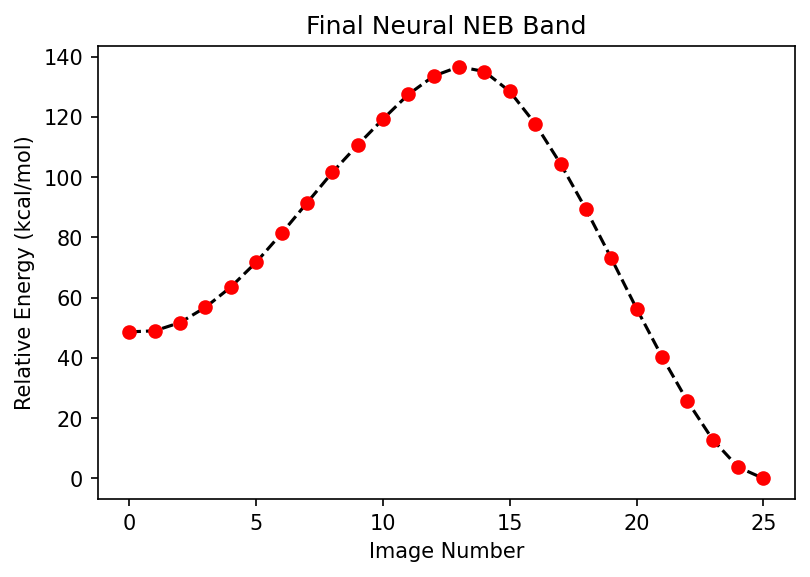

In [11]:
mpl.rcParams['figure.dpi'] = 150

rel_energy = []
for i in range(len(energies)):
    rel_energy.append((energies[i]-np.array(energies).min()) / (kcal/mol))

iteration = [i for i in range(len(energies))]
plt.scatter(iteration, rel_energy, c="r", label='image', zorder=2)

plt.plot(iteration, rel_energy, '--', c="black", label='image', zorder=1)


plt.title("Final Neural NEB Band")
plt.xlabel("Image Number")
plt.ylabel("Relative Energy (kcal/mol)")

plt.show()

In [12]:
ev_atoms = images[highest_image_ind].copy()

ev_atoms = AtomsBatch(ev_atoms, cutoff=5.5, nbr_torch=True, directed=True)

ev_atoms.set_calculator(nff)

## Eigenvector Following from Neural NEB Guess

In [13]:
# ev_run(ev_atoms, nff_dir, maxstepsize, maxstep, convergence, device, method = 'Powell')

device="cuda:0"

xyz, grad, xyz_all, rmslist, maxlist = ev_run(ev_atoms, nff_dir, 0.005, 1000, 0.03, 
                                              device, method='Powell')

Calculating Numerical Hessian using ASE
Writing vib.eq.pckl
Writing vib.0x-.pckl
Writing vib.0x+.pckl
Writing vib.0y-.pckl
Writing vib.0y+.pckl
Writing vib.0z-.pckl
Writing vib.0z+.pckl
Writing vib.1x-.pckl
Writing vib.1x+.pckl
Writing vib.1y-.pckl
Writing vib.1y+.pckl
Writing vib.1z-.pckl
Writing vib.1z+.pckl
Writing vib.2x-.pckl
Writing vib.2x+.pckl
Writing vib.2y-.pckl
Writing vib.2y+.pckl
Writing vib.2z-.pckl
Writing vib.2z+.pckl
Writing vib.3x-.pckl
Writing vib.3x+.pckl
Writing vib.3y-.pckl
Writing vib.3y+.pckl
Writing vib.3z-.pckl
Writing vib.3z+.pckl
Writing vib.4x-.pckl
Writing vib.4x+.pckl
Writing vib.4y-.pckl
Writing vib.4y+.pckl
Writing vib.4z-.pckl
Writing vib.4z+.pckl
Writing vib.5x-.pckl
Writing vib.5x+.pckl
Writing vib.5y-.pckl
Writing vib.5y+.pckl
Writing vib.5z-.pckl
Writing vib.5z+.pckl
Writing vib.6x-.pckl
Writing vib.6x+.pckl
Writing vib.6y-.pckl
Writing vib.6y+.pckl
Writing vib.6z-.pckl
Writing vib.6z+.pckl
Writing vib.7x-.pckl
Writing vib.7x+.pckl
Writing vib.7y-.

RMS: 0.11238712817430496, MAX: 0.5224927067756653
RMS: 0.1109994426369667, MAX: 0.5095987915992737
RMS: 0.1092977300286293, MAX: 0.49696388840675354
RMS: 0.10740384459495544, MAX: 0.48408180475234985
RMS: 0.1057182103395462, MAX: 0.47067803144454956
RMS: 0.10429737716913223, MAX: 0.4574403166770935
RMS: 0.10291889309883118, MAX: 0.44483569264411926
RMS: 0.10137613117694855, MAX: 0.4329407811164856
RMS: 0.09968040138483047, MAX: 0.4212685227394104
RMS: 0.09808441251516342, MAX: 0.4091702699661255
RMS: 0.09669185429811478, MAX: 0.39718174934387207
RMS: 0.09540923684835434, MAX: 0.38604527711868286
RMS: 0.09404507279396057, MAX: 0.37570253014564514
RMS: 0.09265433251857758, MAX: 0.365325003862381
RMS: 0.09139860421419144, MAX: 0.35478705167770386
RMS: 0.0902334600687027, MAX: 0.34505051374435425
RMS: 0.08902924507856369, MAX: 0.33619287610054016
RMS: 0.0878293514251709, MAX: 0.32717424631118774
RMS: 0.08675306290388107, MAX: 0.318103164434433
RMS: 0.08572668582201004, MAX: 0.3101963400840

RMS: 0.020182300359010696, MAX: 0.0693405270576477
RMS: 0.02067513018846512, MAX: 0.07251450419425964
RMS: 0.018952228128910065, MAX: 0.07771054655313492
RMS: 0.01898985542356968, MAX: 0.08031011372804642
RMS: 0.020190035924315453, MAX: 0.08169519156217575
RMS: 0.020880259573459625, MAX: 0.07996540516614914
RMS: 0.02361326478421688, MAX: 0.07454943656921387
RMS: 0.025424910709261894, MAX: 0.09758339077234268
RMS: 0.028148271143436432, MAX: 0.08395972847938538
RMS: 0.02817089483141899, MAX: 0.11077969521284103
RMS: 0.025612933561205864, MAX: 0.10785036534070969
RMS: 0.02417938783764839, MAX: 0.1089586466550827
RMS: 0.02466355822980404, MAX: 0.12347942590713501
RMS: 0.026037631556391716, MAX: 0.11033704876899719
RMS: 0.029274068772792816, MAX: 0.1320003867149353
RMS: 0.02915271185338497, MAX: 0.11601750552654266
RMS: 0.02585817314684391, MAX: 0.13424499332904816
RMS: 0.025522621348500252, MAX: 0.13042867183685303
RMS: 0.02798675000667572, MAX: 0.13323263823986053
RMS: 0.03199899941682815

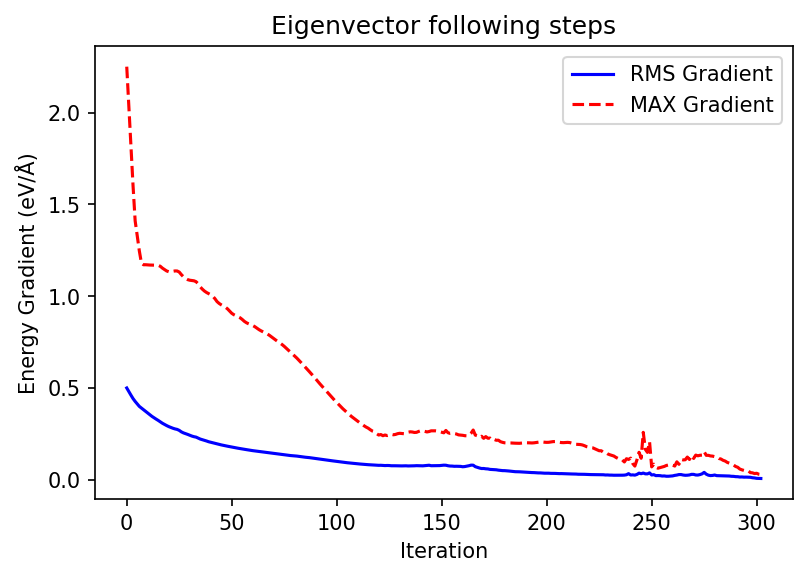

In [14]:
mpl.rcParams['figure.dpi'] = 150

iteration = [i for i in range(len(rmslist))]

rmslist1 = [float(i) for i in rmslist]
maxlist1 = [float(i) for i in maxlist]

plt.plot(iteration, rmslist1, '-', c="b", label='RMS Gradient')
plt.plot(iteration, maxlist1, '--', c="r", label='MAX Gradient')

plt.title("Eigenvector following steps")
plt.xlabel("Iteration")
plt.ylabel("Energy Gradient (eV/Å)")
plt.legend(loc='upper right')

plt.show()

### Comparing the structural difference between true TS and each step of the eigenvector following process

In [15]:
nrrmsdlist = []

f = open('reactive_xyzs/da_ts_m062x_def2svp.xyz', "r")
lines = f.readlines()
ts_geom_xyz = "{}\n\n".format(len(ev_atoms.numbers))
for line in lines[2:]:
    ts_geom_xyz  = ts_geom_xyz  + ("{}\n".format(line))        


for j in range(xyz_all.shape[0]):
    neural_ev_xyz = "{}\n\n".format(len(ev_atoms.numbers))
    for i in range(len(ev_atoms.numbers)):
        neural_ev_xyz = neural_ev_xyz + ("{} {} {} {}\n".format(PERIODICTABLE.GetElementSymbol(int(ev_atoms.numbers[i])),
                                      xyz_all[j][i][0], 
                                      xyz_all[j][i][1], 
                                      xyz_all[j][i][2]))
        
    nrrmsdlist.append(kabsch(1, ts_geom_xyz, neural_ev_xyz, 0, 10000)['RMSD'][0])

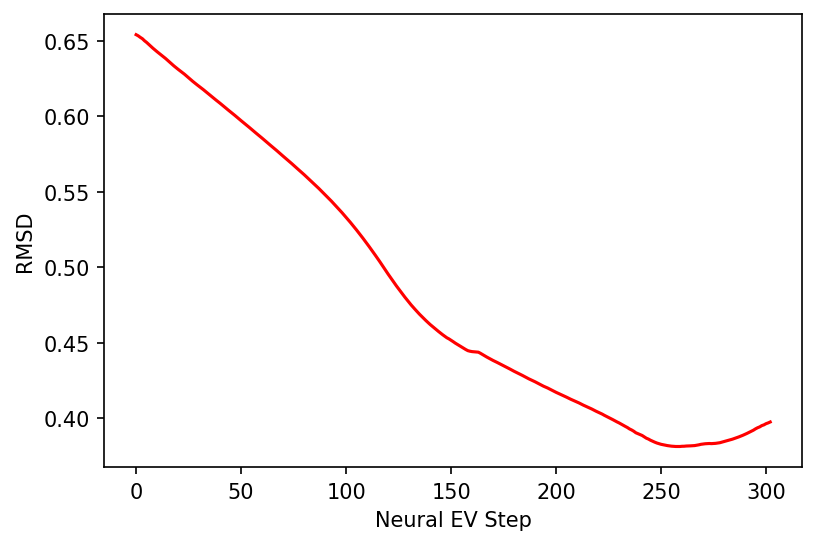

In [16]:
x = [i for i in range(xyz_all.shape[0])]

plt.xlabel('Neural EV Step')
plt.ylabel('RMSD')
plt.plot(x, nrrmsdlist, c='r') 

plt.show()

## Neural Hessian of the DFT refined TS structure

We used the output geometry of the neural eigenvector following algorithm and refined it with M06-2X/def2-SVP level of theory

In [17]:
# M06-2X/def2-SVP quantum mechanical TS coordinates

tsxyzfile = "reactive_xyzs/da_ts_m062x_def2svp.xyz"

In [18]:
ts_atoms = AtomsBatch(xyz_to_ase_atoms(tsxyzfile), cutoff=5.5, nbr_torch=True, directed=True)

ts_atoms.set_calculator(nff)

hessian = neural_hessian_ase(ts_atoms)

r = torch.Tensor([PERIODICTABLE.GetAtomicNumber(i) for i in ts_atoms.get_chemical_symbols()]).reshape(-1,len(ts_atoms.get_chemical_symbols()))
xyz = torch.Tensor(ts_atoms.get_positions().reshape(-1,len(ts_atoms.get_positions()),3))

Calculating Numerical Hessian using ASE
Writing vib.eq.pckl
Writing vib.0x-.pckl
Writing vib.0x+.pckl
Writing vib.0y-.pckl
Writing vib.0y+.pckl
Writing vib.0z-.pckl
Writing vib.0z+.pckl
Writing vib.1x-.pckl
Writing vib.1x+.pckl
Writing vib.1y-.pckl
Writing vib.1y+.pckl
Writing vib.1z-.pckl
Writing vib.1z+.pckl
Writing vib.2x-.pckl
Writing vib.2x+.pckl
Writing vib.2y-.pckl
Writing vib.2y+.pckl
Writing vib.2z-.pckl
Writing vib.2z+.pckl
Writing vib.3x-.pckl
Writing vib.3x+.pckl
Writing vib.3y-.pckl
Writing vib.3y+.pckl
Writing vib.3z-.pckl
Writing vib.3z+.pckl
Writing vib.4x-.pckl
Writing vib.4x+.pckl
Writing vib.4y-.pckl
Writing vib.4y+.pckl
Writing vib.4z-.pckl
Writing vib.4z+.pckl
Writing vib.5x-.pckl
Writing vib.5x+.pckl
Writing vib.5y-.pckl
Writing vib.5y+.pckl
Writing vib.5z-.pckl
Writing vib.5z+.pckl
Writing vib.6x-.pckl
Writing vib.6x+.pckl
Writing vib.6y-.pckl
Writing vib.6y+.pckl
Writing vib.6z-.pckl
Writing vib.6z+.pckl
Writing vib.7x-.pckl
Writing vib.7x+.pckl
Writing vib.7y-.

### Projecting translational and rotational modes

In [19]:
force_constants_J_m_2, proj_vib_freq_cm_1, proj_hessian_eigvec = vib_analy(r.cpu().numpy(),xyz.cpu().numpy(),
                                                                           hessian)

## Reactive Langevin MD

Pairs of Langevin MD trajectories initiated in the vicinity of transition state in the forward and backward directions.

In [20]:
md_params = {
    'T_init': 298.15, # Temperature in K
    'friction': 0.0012, # Langevin friction coefficient
    'time_step': 1 , 
    'thermostat': Langevin, 
    'steps': 500,
    'save_frequency': 1, # Save every n frames
    'nbr_list_update_freq': 5, # Neighbor list update frequency
    'thermo_filename': './thermo1.log', 
    'traj_filename': './atom1.traj',
    'skip': 0
}

### Running *n_traj* pairs of reactive MD

In [21]:
n_traj = 1
device = "cuda:1"

In [22]:
for iteration in range(n_traj):
    
    # Sampling of initial structure and velocities
    
    disp_xyz, vel_plus, vel_minus = reactive_normal_mode_sampling(xyz.cpu().numpy(),
                                                              force_constants_J_m_2, 
                                                              proj_vib_freq_cm_1, 
                                                              proj_hessian_eigvec,
                                                              md_params['T_init'])
    
    for sign in ['minus','plus']:

        reactmdatoms = Atoms(symbols=[PERIODICTABLE.GetElementSymbol(int(i)) for i in list(r.reshape(-1))],
                               positions=torch.Tensor(disp_xyz.reshape(-1,3)),
                               pbc=False)
        
        reactmd_atoms = AtomsBatch(reactmdatoms, cutoff=5.5, nbr_torch=True, directed=True)
        
        nff_ase = NeuralFF.from_file(nff_dir, device=device)
        reactmd_atoms.set_calculator(nff_ase)
        
        if sign == 'minus':            
            vel = vel_minus
        else:            
            vel = vel_plus    
            
        react_nvt = Reactive_Dynamics(reactmd_atoms, vel, md_params)
        react_nvt.run()

        react_nvt.save_as_xyz("test_iter{}_{}.xyz".format(iteration, sign))

Time[ps]      Etot[eV]     Epot[eV]     Ekin[eV]    T[K]
0.0000           9.1347       8.4143       0.7204   309.6

0.0010           9.1418       8.5120       0.6298   270.7

0.0020           9.1502       8.6911       0.4591   197.3

0.0030           9.1493       8.8000       0.3492   150.1

0.0040           9.1434       8.8043       0.3391   145.7

0.0050           9.1374       8.7816       0.3558   152.9

0.0060           9.1360       8.7986       0.3374   145.0

0.0070           9.1411       8.8391       0.3019   129.8

0.0080           9.1462       8.8175       0.3287   141.3

0.0090           9.1381       8.7018       0.4363   187.5

0.0100           9.1312       8.5892       0.5420   232.9

0.0110           9.1305       8.5922       0.5383   231.4

0.0120           9.1407       8.6948       0.4459   191.7

0.0130           9.1473       8.7591       0.3882   166.8

0.0140           9.1425       8.6943       0.4482   192.6

0.0150           9.1356       8.5670       0.5686   244.4


0.1380           9.1236       7.4353       1.6883   725.6

0.1390           9.1194       7.4063       1.7131   736.3

0.1400           9.1150       7.4121       1.7028   731.9

0.1410           9.1166       7.4854       1.6313   701.1

0.1420           9.1129       7.5722       1.5407   662.2

0.1430           9.1220       7.5744       1.5476   665.2

0.1440           9.1109       7.4586       1.6522   710.1

0.1450           9.1044       7.2780       1.8264   785.0

0.1460           9.1003       7.1096       1.9907   855.6

0.1470           9.1058       6.9775       2.1283   914.8

0.1480           9.1020       6.8759       2.2261   956.8

0.1490           9.1027       6.8110       2.2917   985.0

0.1500           9.1015       6.8197       2.2818   980.7

0.1510           9.1047       6.9463       2.1584   927.7

0.1520           9.1120       7.1936       1.9184   824.5

0.1530           9.1174       7.4643       1.6531   710.5

0.1540           9.1160       7.6347       1.4813   636.

0.2820           9.0909       6.7867       2.3042   990.4

0.2830           9.0944       6.8451       2.2493   966.7

0.2840           9.0874       6.8660       2.2214   954.8

0.2850           9.0794       6.9336       2.1458   922.2

0.2860           9.0783       7.0757       2.0027   860.7

0.2870           9.0739       7.2628       1.8111   778.4

0.2880           9.0758       7.4633       1.6125   693.0

0.2890           9.0802       7.6133       1.4669   630.5

0.2900           9.0769       7.6363       1.4406   619.2

0.2910           9.0675       7.5509       1.5166   651.8

0.2920           9.0610       7.4616       1.5994   687.4

0.2930           9.0633       7.3830       1.6804   722.2

0.2940           9.0553       7.2014       1.8539   796.8

0.2950           9.0356       6.9595       2.0761   892.3

0.2960           9.0265       6.8329       2.1936   942.8

0.2970           9.0287       6.8732       2.1556   926.4

0.2980           9.0374       7.0090       2.0284   871.

0.4230           8.9272       7.5947       1.3325   572.7

0.4240           8.9098       7.4223       1.4876   639.4

0.4250           8.9166       7.4071       1.5096   648.8

0.4260           8.9323       7.5116       1.4206   610.6

0.4270           8.9356       7.5098       1.4257   612.8

0.4280           8.9303       7.3622       1.5681   674.0

0.4290           8.9291       7.1534       1.7757   763.2

0.4300           8.9216       6.9212       2.0005   859.8

0.4310           8.9048       6.7588       2.1459   922.3

0.4320           8.9146       6.7731       2.1415   920.4

0.4330           8.9305       6.8447       2.0858   896.5

0.4340           8.9132       6.8251       2.0881   897.5

0.4350           8.9117       6.9005       2.0112   864.4

0.4360           8.9359       7.1994       1.7364   746.3

0.4370           8.9499       7.5119       1.4380   618.0

0.4380           8.9436       7.6404       1.3032   560.1

0.4390           8.9362       7.6362       1.3000   558.

0.0650           9.1435       7.9246       1.2189   523.9

0.0660           9.1393       7.9022       1.2371   531.7

0.0670           9.1399       7.9493       1.1906   511.7

0.0680           9.1438       8.0349       1.1089   476.6

0.0690           9.1514       8.0757       1.0757   462.3

0.0700           9.1402       8.0334       1.1068   475.7

0.0710           9.1344       7.9872       1.1472   493.1

0.0720           9.1401       8.0291       1.1110   477.5

0.0730           9.1456       8.1290       1.0166   436.9

0.0740           9.1471       8.2077       0.9394   403.8

0.0750           9.1437       8.2528       0.8909   382.9

0.0760           9.1508       8.2895       0.8614   370.2

0.0770           9.1520       8.3215       0.8305   357.0

0.0780           9.1567       8.3382       0.8185   351.8

0.0790           9.1592       8.3299       0.8293   356.4

0.0800           9.1571       8.2855       0.8716   374.6

0.0810           9.1528       8.2361       0.9167   394.

0.2040           9.1381       8.2806       0.8575   368.5

0.2050           9.1510       8.3754       0.7756   333.4

0.2060           9.1435       8.2923       0.8512   365.8

0.2070           9.1314       8.0656       1.0658   458.1

0.2080           9.1225       7.9276       1.1949   513.6

0.2090           9.1295       7.9487       1.1808   507.5

0.2100           9.1322       7.9842       1.1480   493.4

0.2110           9.1185       7.9719       1.1466   492.8

0.2120           9.1104       7.9997       1.1107   477.4

0.2130           9.1133       8.1105       1.0028   431.0

0.2140           9.1149       8.2472       0.8677   372.9

0.2150           9.1168       8.3493       0.7674   329.8

0.2160           9.1158       8.3877       0.7282   313.0

0.2170           9.1108       8.3655       0.7453   320.3

0.2180           9.1075       8.3293       0.7782   334.5

0.2190           9.1074       8.3131       0.7943   341.4

0.2200           9.1075       8.3017       0.8058   346.

0.3490           9.0737       8.1844       0.8894   382.2

0.3500           9.0819       8.2342       0.8477   364.3

0.3510           9.0936       8.2655       0.8281   355.9

0.3520           9.0881       8.1631       0.9249   397.5

0.3530           9.0806       8.0507       1.0299   442.6

0.3540           9.0787       8.0634       1.0153   436.4

0.3550           9.0889       8.1409       0.9480   407.4

0.3560           9.0943       8.1791       0.9152   393.4

0.3570           9.0874       8.1207       0.9666   415.5

0.3580           9.0772       8.0173       1.0599   455.5

0.3590           9.0801       7.9894       1.0907   468.8

0.3600           9.0889       8.0142       1.0747   461.9

0.3610           9.0918       7.9512       1.1406   490.2

0.3620           9.0769       7.8325       1.2444   534.9

0.3630           9.0773       7.8140       1.2632   542.9

0.3640           9.0879       7.9024       1.1856   509.5

0.3650           9.0886       7.9757       1.1129   478.

0.4880           9.0406       7.8346       1.2060   518.3

0.4890           9.0488       7.9424       1.1064   475.5

0.4900           9.0495       8.0469       1.0026   430.9

0.4910           9.0420       8.0498       0.9922   426.4

0.4920           9.0330       7.9987       1.0343   444.5

0.4930           9.0332       7.9901       1.0431   448.3

0.4940           9.0397       8.0384       1.0013   430.4

0.4950           9.0434       8.0404       1.0030   431.1

0.4960           9.0335       7.9325       1.1010   473.2

0.4970           9.0260       7.8176       1.2084   519.4

0.4980           9.0232       7.7954       1.2277   527.7

0.4990           9.0260       7.8544       1.1716   503.6

0.5000           9.0331       7.9069       1.1262   484.0

